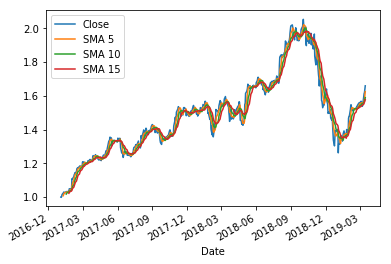

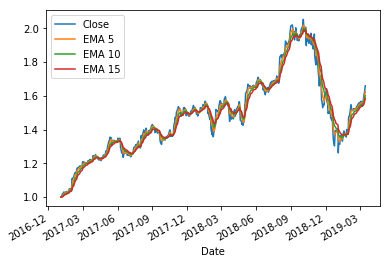

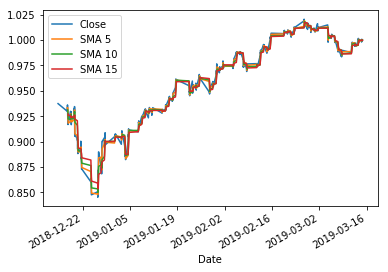

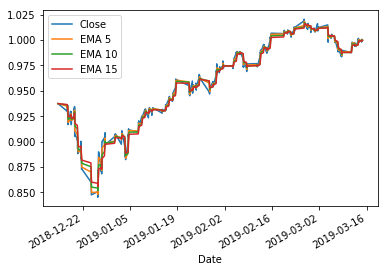

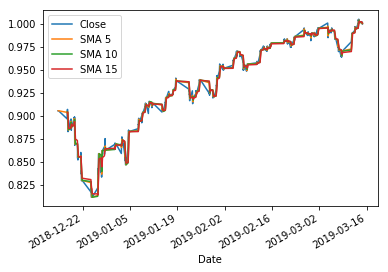

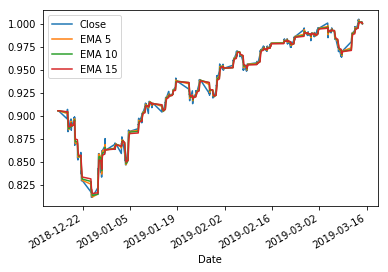

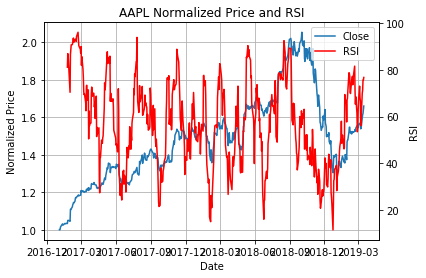

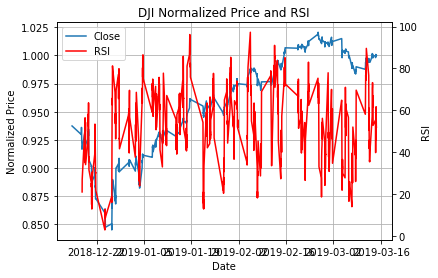

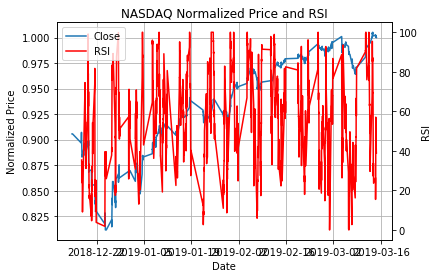

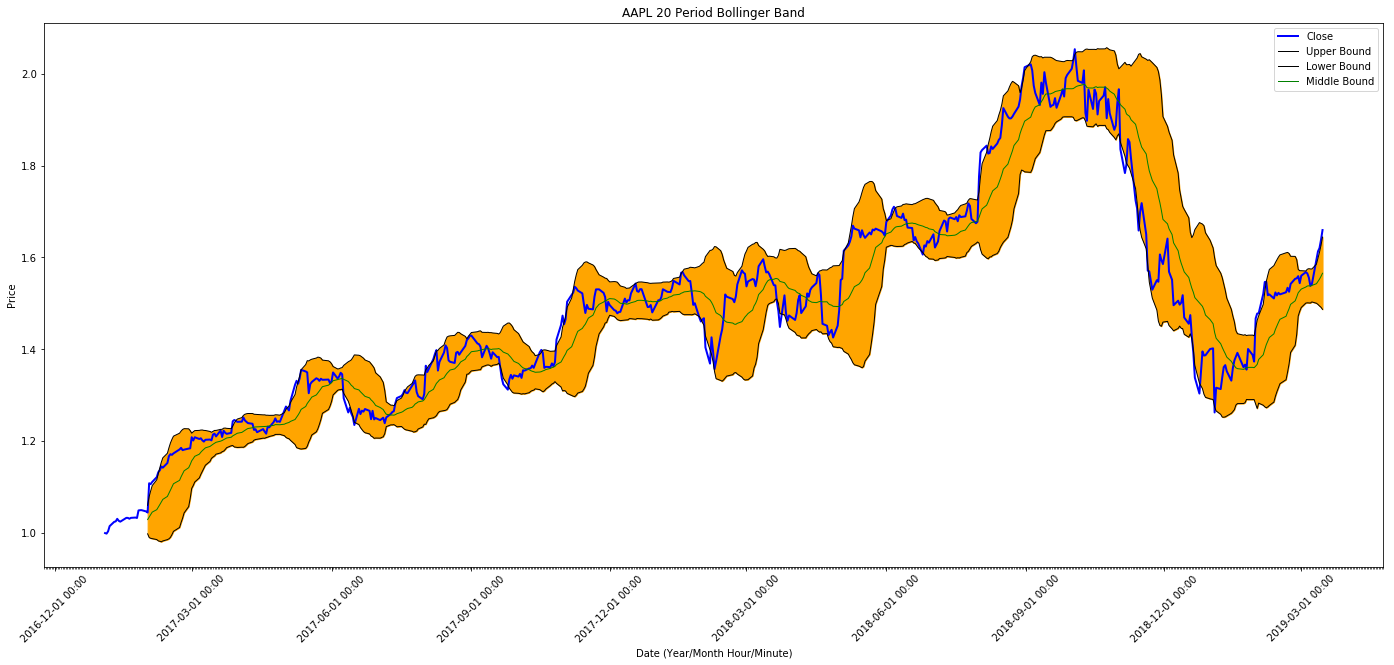

0.118034513783
hello


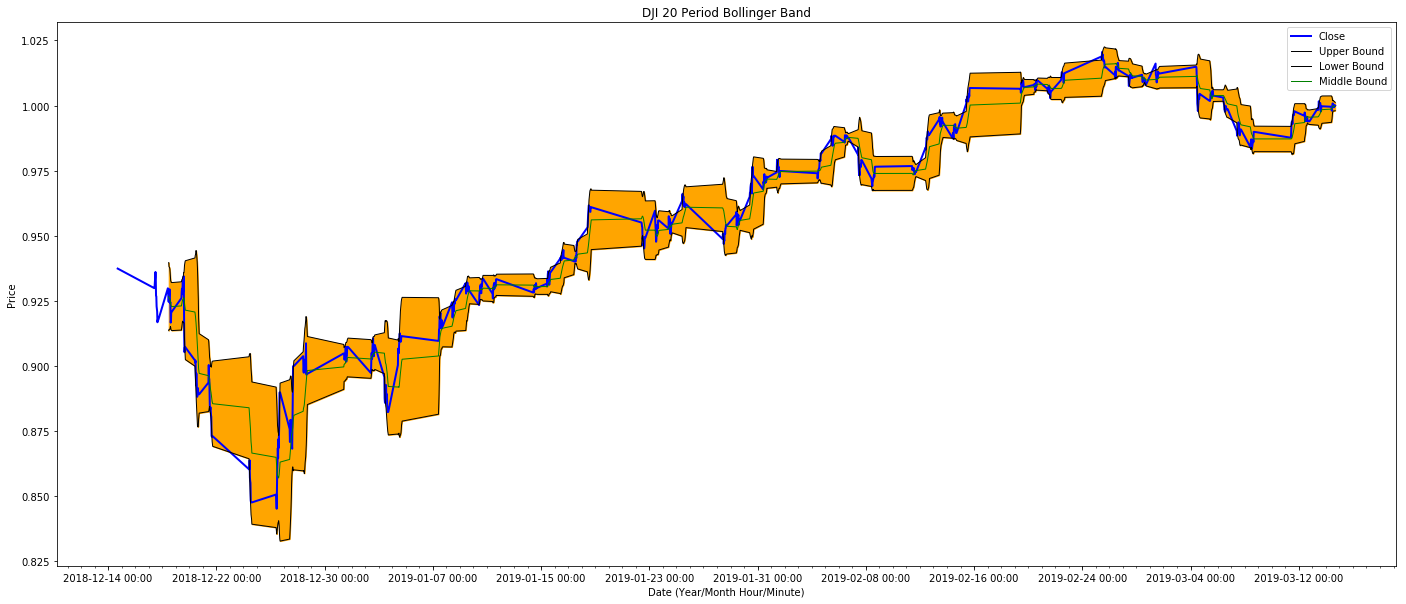

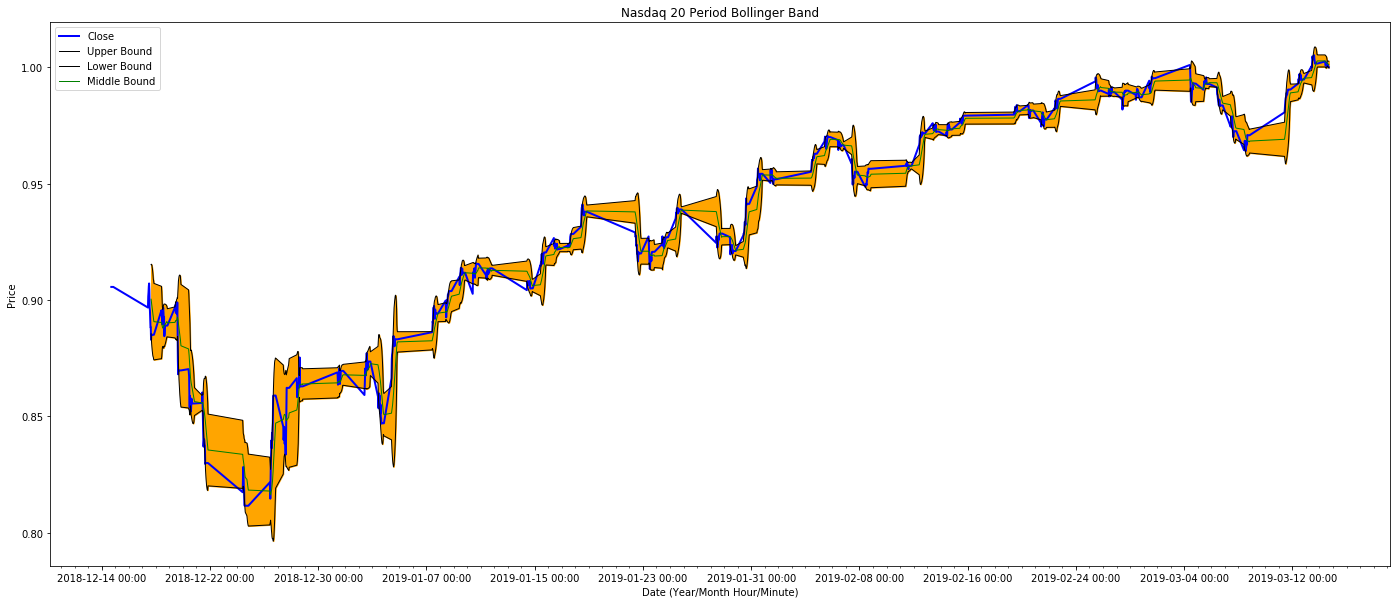

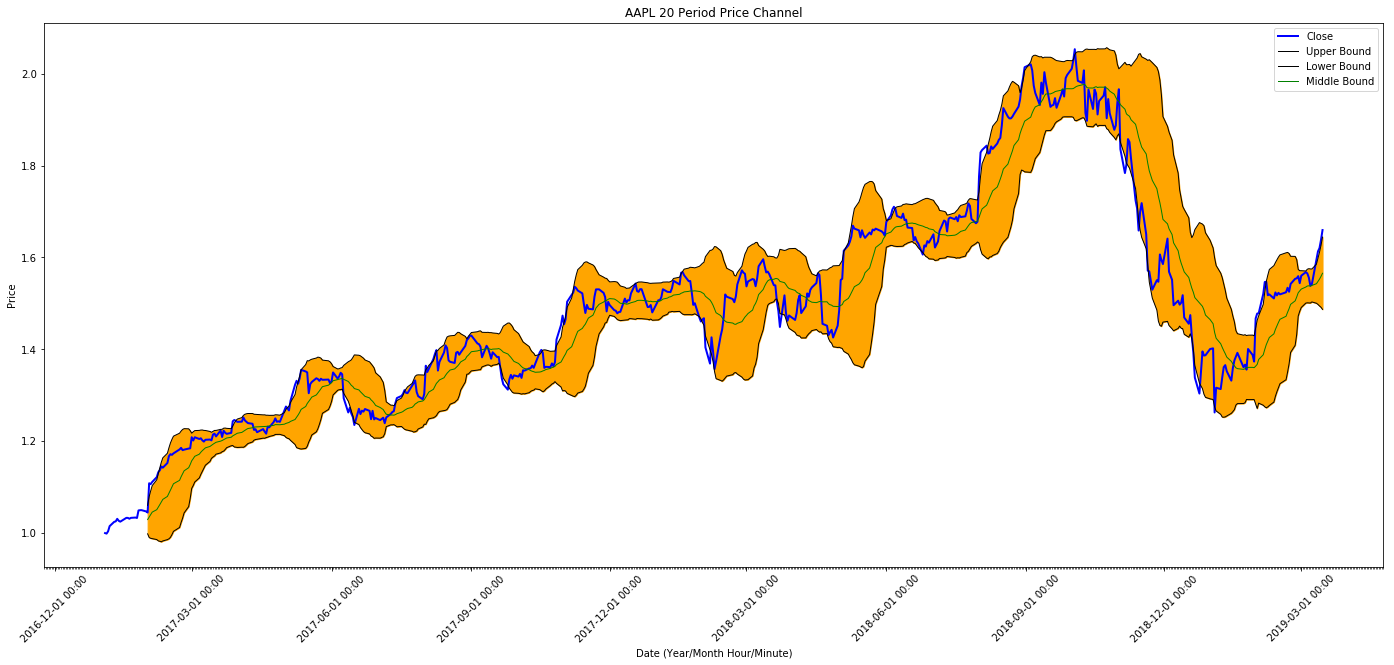

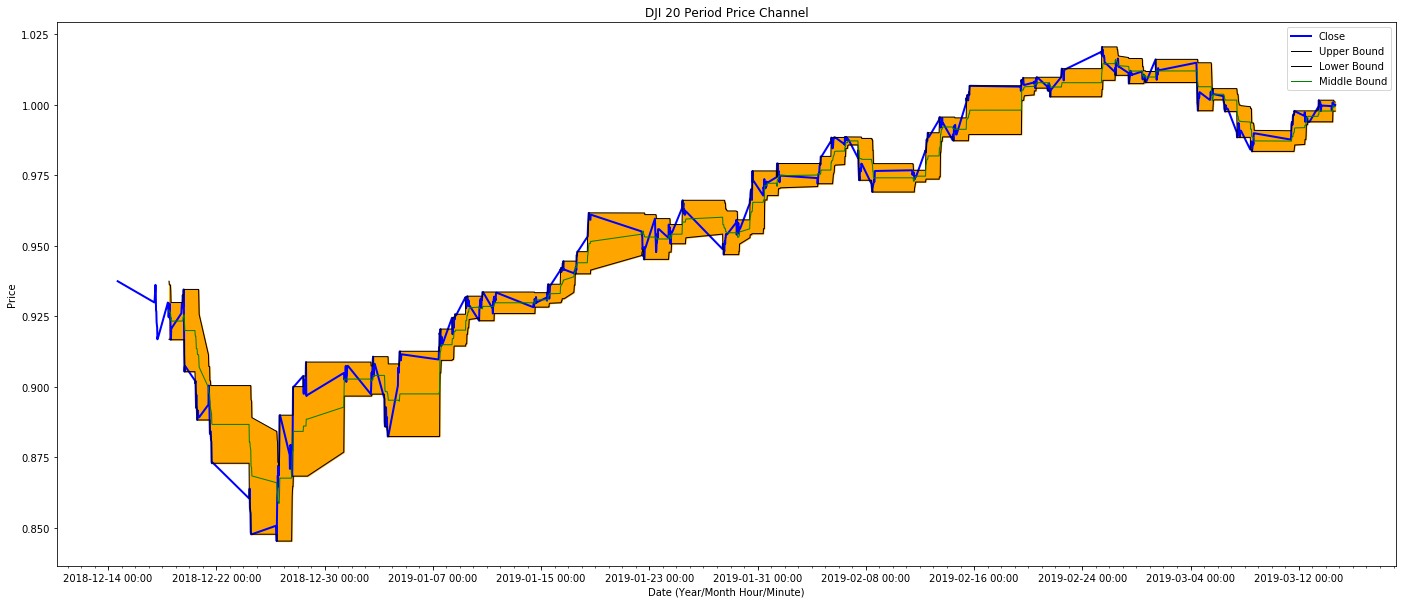

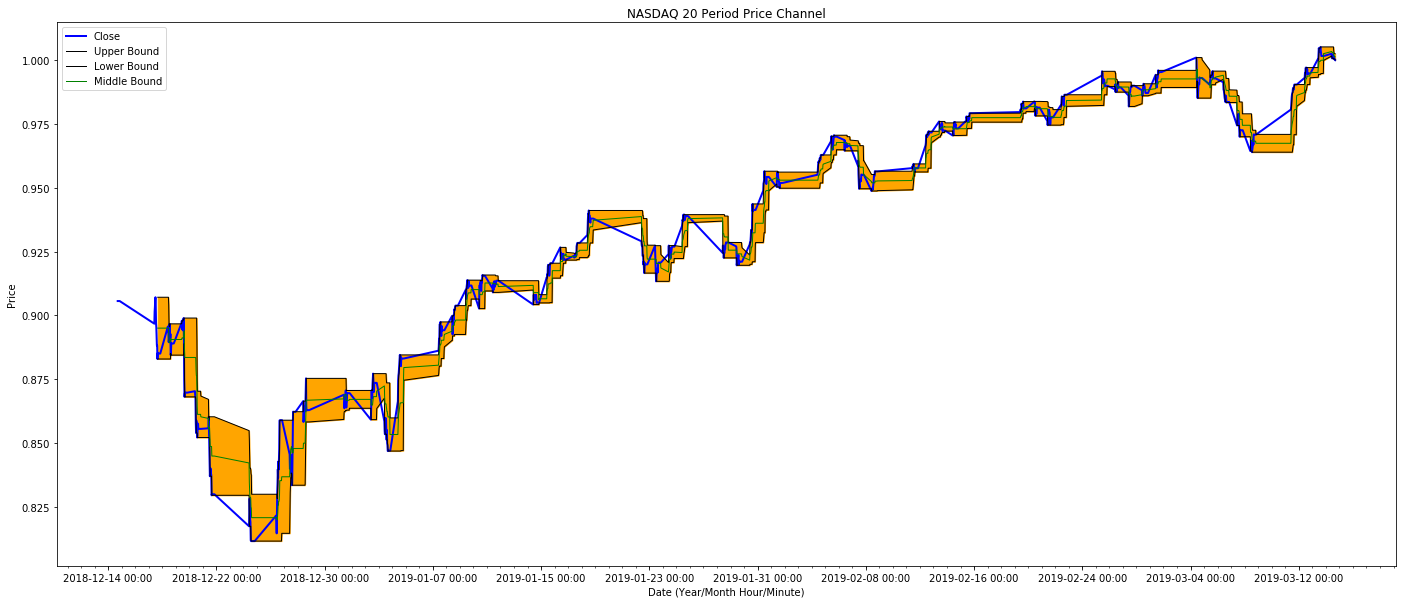

In [2]:
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
import matplotlib as mpl
#%matplotlib
#
def sma_ema(DJIdata, file_name, directory):

    DJIdata['ROI'] = DJIdata['Close'].pct_change()
    data = DJIdata[['Date','Close']]

    # Calculating the short-window simple moving average
    # Put the data into the dataframe
    for i in (5,10,15):
        short_rolling = data.set_index('Date').rolling(window=i).mean()
        DJIdata['SMA ' + str(i)] = short_rolling.values

    # BuySignal1 (SMA 5 crosses SMA 10)
    buySignal1 = []
    for i in range (0, DJIdata.shape[0]):
        if  np.isnan(DJIdata['SMA 10'][i]) == True:
            buySignal1.append("NA")
        elif (DJIdata['SMA 5'][i] > DJIdata['SMA 10'][i]) and (DJIdata['SMA 5'][i-1] < DJIdata['SMA 10'][i-1]) :
            buySignal1.append(1)
        else:
            buySignal1.append(0)

    DJIdata['buySignal1'] =buySignal1

    # BuySignal2 (SMA 5 crosses SMA 10)
    buySignal2 = []
    for i in range (0, DJIdata.shape[0]):
        if np.isnan(DJIdata['SMA 15'][i]) == True:
            buySignal2.append("NA")
        elif (DJIdata['SMA 10'][i] > DJIdata['SMA 15'][i]) and (DJIdata['SMA 10'][i-1] < DJIdata['SMA 15'][i-1]) :
            buySignal2.append(1)
        else:
            buySignal2.append(0)

    DJIdata['buySignal2'] = buySignal2

   # SellSignal1 (SMA 5 crosses SMA 10)
    sellSignal1 = []
    for i in range (0, DJIdata.shape[0]):
        if  np.isnan(DJIdata['SMA 10'][i]) == True:
            sellSignal1.append("NA")
        elif (DJIdata['SMA 5'][i] < DJIdata['SMA 10'][i]) and (DJIdata['SMA 5'][i-1] > DJIdata['SMA 10'][i-1]) :
            sellSignal1.append(1)
        else:
            sellSignal1.append(0)

    DJIdata['sellSignal1'] = sellSignal1

    # SellSignal2 (SMA 10 crosses SMA 15)
    sellSignal2 = []
    for i in range (0, DJIdata.shape[0]):
        if np.isnan(DJIdata['SMA 15'][i]) == True:
            sellSignal2.append("NA")
        elif (DJIdata['SMA 10'][i] < DJIdata['SMA 15'][i]) and (DJIdata['SMA 10'][i-1] > DJIdata['SMA 15'][i-1]) :
            sellSignal2.append(1)
        else:
            sellSignal2.append(0)

    DJIdata['sellSignal2'] = sellSignal2


    closePriceSMA5 = []
    closePriceSMA10 = []
    closePriceSMA15 = []

    # Dividing closePrice with SMA5/10/15
    for i in range (0,DJIdata.shape[0]):
        if np.isnan(DJIdata['SMA 15'][i]) == True :
            closePriceSMA15.append("NA")
        if np.isnan(DJIdata['SMA 15'][i]) == False :
            closePriceSMA15.append(DJIdata['Close'][i] / DJIdata['SMA 15'][i])
        if np.isnan(DJIdata['SMA 10'][i]) == True :
            closePriceSMA10.append("NA")
        if np.isnan(DJIdata['SMA 10'][i]) == False :
            closePriceSMA10.append(DJIdata['Close'][i] / DJIdata['SMA 10'][i])
        if np.isnan(DJIdata['SMA 5'][i]) == True :
            closePriceSMA5.append("NA")
        if np.isnan(DJIdata['SMA 5'][i]) == False :
            closePriceSMA5.append(DJIdata['Close'][i] / DJIdata['SMA 5'][i])

    # Inputting ClosePrice/SMA 5/10/15 into dataframe
    DJIdata['closePriceSMA5'] = closePriceSMA5
    DJIdata['closePriceSMA10'] = closePriceSMA10
    DJIdata['closePriceSMA15'] = closePriceSMA15

    state = []
    for i in range(0,DJIdata.shape[0]):
        if DJIdata['buySignal1'][i] == "NA" :
            state.append("NA")
        elif DJIdata['buySignal1'][i] == 1 and state[i-1] == "NA" :
            state.append("long")
        elif DJIdata['buySignal1'][i] == 1 and state[i-1] == "exit" :
            state.append("long")
        elif DJIdata['buySignal1'][i] == 1 and state[i-1] == "long" :
            state.append("long")
        elif DJIdata['buySignal1'][i] == 1 and state[i-1] == "short" :
            state.append("exit")
        elif DJIdata['sellSignal1'][i] == 1 and state[i-1] == "NA" :
            state.append("short")
        elif DJIdata['sellSignal1'][i] == 1 and state[i-1] == "exit" :
            state.append("short")
        elif DJIdata['sellSignal1'][i] == 1 and state[i-1] == "short" :
            state.append("short")
        elif DJIdata['sellSignal1'][i] == 1 and state[i-1] == "long" :
            state.append("exit")
        elif DJIdata['sellSignal1'][i] == 0 and DJIdata['buySignal1'][i] == 0 :
            state.append(state[i-1])

    DJIdata['state'] = state
    exit_Signal_SMA = []

    TP = (DJIdata['High'] + DJIdata['Low'] + DJIdata['Close']) / 3
    CCI = pd.Series((TP - TP.rolling(20).mean()) / (0.015 * TP.rolling(20).std()),
    name = 'CCI')
    DJIdata['CCI'] = CCI

    for i in range(0, DJIdata.shape[0]) :
        if DJIdata['CCI'][i] > 100 and DJIdata['state'][i] == 'long' and DJIdata['buySignal1'][i] == 0 and DJIdata['sellSignal1'][i] == 0 :
            exit_Signal_SMA.append(1)

        elif DJIdata['CCI'][i] < -100 and DJIdata['state'][i] == 'short' and DJIdata['buySignal1'][i] == 0 and DJIdata['sellSignal1'][i] == 0 :
            exit_Signal_SMA.append(1)
        else:
            exit_Signal_SMA.append(0)

    DJIdata['exit_Signal_SMA'] = exit_Signal_SMA


    DJIdataSMA = DJIdata[['Date', 'Close' , 'SMA 5' , 'SMA 10' , 'SMA 15', 'state' ,
                           'closePriceSMA5' , 'closePriceSMA10', 'closePriceSMA15',
                          'sellSignal1' , 'sellSignal2' , 'buySignal1' , 'buySignal2', 'exit_Signal_SMA']]

    DJIdataSMA.to_csv(directory + '/SMA_' + file_name + '.csv',index=False)



    #Exponential Moving Average -------------------------------------------------------------------------------------


    for i in (5,10,15):
        ema_short = data.set_index('Date').ewm(span=i, adjust=False).mean()
        DJIdata['EMA ' + str(i)] = ema_short.values

    # BuySignal1 (EMA 5 crosses EMA 10)
    buySignal1EMA = []
    for i in range (0, DJIdata.shape[0]):
        if  np.isnan(DJIdata['EMA 10'][i]) == True:
            buySignal1EMA.append("NA")
        elif (DJIdata['EMA 5'][i] > DJIdata['EMA 10'][i]) and (DJIdata['EMA 5'][i-1] < DJIdata['EMA 10'][i-1]) :
            buySignal1EMA.append(1)
        else:
            buySignal1EMA.append(0)

    DJIdata['buySignal1EMA'] = buySignal1EMA

    # BuySignal1 (EMA 10 crosses EMA 15)
    buySignal2EMA = []
    for i in range (0, DJIdata.shape[0]):
        if np.isnan(DJIdata['EMA 15'][i]) == True:
            buySignal2EMA.append("NA")
        elif (DJIdata['EMA 10'][i] > DJIdata['EMA 15'][i]) and (DJIdata['EMA 10'][i-1] < DJIdata['EMA 15'][i-1]) :
            buySignal2EMA.append(1)
        else:
            buySignal2EMA.append(0)

    DJIdata['buySignal2EMA'] = buySignal2EMA

    # SellSignal1 (EMA 5 crosses EMA 10)
    sellSignal1EMA = []
    for i in range (0, DJIdata.shape[0]):
        if  np.isnan(DJIdata['SMA 10'][i]) == True:
            sellSignal1EMA.append("NA")
        elif (DJIdata['SMA 5'][i] < DJIdata['SMA 10'][i]) and (DJIdata['SMA 5'][i-1] > DJIdata['SMA 10'][i-1]) :
            sellSignal1EMA.append(1)
        else:
            sellSignal1EMA.append(0)

    DJIdata['sellSignal1EMA'] = sellSignal1EMA

    # SellSignal1 (EMA 5 crosses EMA 10)
    sellSignal2EMA = []
    for i in range (0, DJIdata.shape[0]):
        if np.isnan(DJIdata['SMA 15'][i]) == True:
            sellSignal2EMA.append("NA")
        elif (DJIdata['SMA 10'][i] < DJIdata['SMA 15'][i]) and (DJIdata['SMA 10'][i-1] > DJIdata['SMA 15'][i-1]) :
            sellSignal2EMA.append(1)
        else:
            sellSignal2EMA.append(0)

    DJIdata['sellSignal2EMA'] = sellSignal2EMA

    closePriceEMA5 = []
    closePriceEMA10 = []
    closePriceEMA15 = []

    # Dividing closePrice with EMA5/10/15
    for i in range (0,DJIdata.shape[0]):
        if np.isnan(DJIdata['EMA 15'][i]) == True :
            closePriceEMA15.append("NA")
        if np.isnan(DJIdata['EMA 15'][i]) == False :
            closePriceEMA15.append(DJIdata['Close'][i] / DJIdata['EMA 15'][i])
        if np.isnan(DJIdata['EMA 10'][i]) == True :
            closePriceEMA10.append("NA")
        if np.isnan(DJIdata['EMA 10'][i]) == False :
            closePriceEMA10.append(DJIdata['Close'][i] / DJIdata['EMA 10'][i])
        if np.isnan(DJIdata['EMA 5'][i]) == True :
            closePriceEMA5.append("NA")
        if np.isnan(DJIdata['EMA 5'][i]) == False :
            closePriceEMA5.append(DJIdata['Close'][i] / DJIdata['EMA 5'][i])

    # Inputting ClosePrice/EMA 5/10/15 into dataframe
    DJIdata['closePriceEMA5'] = closePriceEMA5
    DJIdata['closePriceEMA10'] = closePriceEMA10
    DJIdata['closePriceEMA15'] = closePriceEMA15


    state_EMA = []
    for i in range(0,DJIdata.shape[0]):
        if DJIdata['sellSignal1EMA'][i] == "NA" :
            state_EMA.append("NA")
        elif DJIdata['buySignal1EMA'][i] == 1 and state_EMA[i-1] == "NA" :
            state_EMA.append("long")
        elif DJIdata['buySignal1EMA'][i] == 1 and state_EMA[i-1] == "exit" :
            state_EMA.append("long")
        elif DJIdata['buySignal1EMA'][i] == 1 and state_EMA[i-1] == "long" :
            state_EMA.append("long")
        elif DJIdata['buySignal1EMA'][i] == 1 and state_EMA[i-1] == "short" :
            state_EMA.append("exit")
        elif DJIdata['sellSignal1EMA'][i] == 1 and state_EMA[i-1] == "NA" :
            state_EMA.append("short")
        elif DJIdata['sellSignal1EMA'][i] == 1 and state_EMA[i-1] == "exit" :
            state_EMA.append("short")
        elif DJIdata['sellSignal1EMA'][i] == 1 and state_EMA[i-1] == "short" :
            state_EMA.append("short")
        elif DJIdata['sellSignal1EMA'][i] == 1 and state_EMA[i-1] == "long" :
            state_EMA.append("exit")
        elif DJIdata['sellSignal1EMA'][i] == 0 and DJIdata['buySignal1EMA'][i] == 0 :
            state_EMA.append(state[i-1])

    DJIdata['state_EMA'] = state_EMA

    exit_Signal_EMA = []

    TP = (DJIdata['High'] + DJIdata['Low'] + DJIdata['Close']) / 3
    CCI_EMA = pd.Series((TP - TP.rolling(20).mean()) / (0.015 * TP.rolling(20).std()),
    name = 'CCI_EMA')
    DJIdata['CCI_EMA'] = CCI_EMA

    for i in range(0, DJIdata.shape[0]) :
        if DJIdata['CCI_EMA'][i] > 100 and DJIdata['state_EMA'][i] == 'long' and DJIdata['buySignal1EMA'][i] == 0 and DJIdata['sellSignal1'][i] == 0 :
            exit_Signal_EMA.append(1)

        elif DJIdata['CCI_EMA'][i] < -100 and DJIdata['state_EMA'][i] == 'short' and DJIdata['buySignal1EMA'][i] == 0 and DJIdata['sellSignal1EMA'][i] == 0 :
            exit_Signal_EMA.append(1)
        else:
            exit_Signal_EMA.append(0)

    DJIdata['exit_Signal_EMA'] = exit_Signal_EMA

    #Making dataframes for both EMA and SMA to plot on
    plotdf1 = DJIdata[['Date', 'Close' , 'SMA 5' , 'SMA 10' , 'SMA 15']]
    plotdf1.plot(x='Date')

    plotdf2 = DJIdata[['Date', 'Close' , 'EMA 5' , 'EMA 10' , 'EMA 15']]
    plotdf2.plot(x='Date')

    #Outputting the dataframe to csv
    #DJIdata.to_csv('SMA+EMA_' + file_name + '.csv',index=False)


    DJIdataEMA = DJIdata[['Date', 'Close' , 'EMA 5' , 'EMA 10' , 'EMA 15', 'state' ,
                           'closePriceEMA5' , 'closePriceEMA10', 'closePriceEMA15',
                          'sellSignal1EMA' , 'sellSignal2EMA' , 'buySignal1EMA' , 'buySignal2EMA', 'exit_Signal_EMA']]

    DJIdataEMA.to_csv(directory + '/EMA_' + file_name + '.csv',index=False)




def AAPL_RSI(df):
    df['ROI'] = df['Close'].pct_change()

    dUp = df['ROI'].copy()
    dDown = df['ROI'].copy()

    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    avgUp = dUp.rolling(14).mean()
    avgDown = dDown.rolling(14).mean()
    avgDown = avgDown.abs()

    df['Avg Up'] = avgUp
    df['Avg Down'] = avgDown

    df['RS'] = df['Avg Up']/df['Avg Down']
    df['RSI'] = 100 - (100/(1+df['RS']))

    # create sell/buy signals
    sell = []
    buy = []
    q = deque([50, 50, 50, 50, 50], maxlen=5)

    for rsi in df['RSI']:
        q.append(rsi)
        # check for sell signal
        if (rsi < 70 and q[3] > 70) and (q[0] > 70 or q[1] > 70 or q[2] > 70 or q[3] > 70 or q[4] > 70):
            sell.append(1)
        else:
            sell.append(0)

        # check for buy signal
        if (rsi > 30 and q[3] < 30) and (q[0] < 30 or q[1] < 30 or q[2] < 30 or q[3] < 30 or q[4] < 30):
            buy.append(1)
        else:
            buy.append(0)

    df['Sell Signal'] = sell
    df['Buy Signal'] = buy

    df_csv = df[['Close', 'ROI', 'RSI', 'Sell Signal', 'Buy Signal']]
    df_csv.to_csv('AAPL/AAPL-RSI.csv')

    # create the plot
    fig, ax = plt.subplots()
    ax.plot(df['Date'], df['Close'])
    ax.set(xlabel='Date', ylabel='Normalized Price', title='AAPL Normalized Price and RSI')
    ax.grid()

    ax2 = ax.twinx()
    ax2.plot(df['Date'], df['RSI'], 'r')
    ax2.set_ylabel('RSI')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2, loc=0)
    plt.show()

def RSI(df, s):
    df['ROI'] = df['Close'].pct_change()

    dUp = df['ROI'].copy()
    dDown = df['ROI'].copy()

    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    avgUp = dUp.rolling(14).mean()
    avgDown = dDown.rolling(14).mean()
    avgDown = avgDown.abs()

    df['Avg Up'] = avgUp
    df['Avg Down'] = avgDown

    df['RS'] = df['Avg Up']/df['Avg Down']
    df['RSI'] = 100 - (100/(1+df['RS']))

    # create sell/buy signals
    sell = []
    buy = []
    q = deque([50, 50, 50, 50, 50], maxlen=5)

    for rsi in df['RSI']:
        q.append(rsi)
        # check for sell signal
        if (rsi < 70 and q[3] > 70) and (q[0] > 70 or q[1] > 70 or q[2] > 70 or q[3] > 70 or q[4] > 70):
            sell.append(1)
        else:
            sell.append(0)

        # check for buy signal
        if (rsi > 30 and q[3] < 30) and (q[0] < 30 or q[1] < 30 or q[2] < 30 or q[3] < 30 or q[4] < 30):
            buy.append(1)
        else:
            buy.append(0)

    df['Sell Signal'] = sell
    df['Buy Signal'] = buy

    df_csv = df[['Close', 'ROI', 'RSI', 'Sell Signal', 'Buy Signal']]
    df_csv.to_csv('{}30/{}-RSI.csv'.format(s, s))

    # create the plot
    fig, ax = plt.subplots()
    ax.plot(df['Date'], df['Close'])
    ax.set(xlabel='Date', ylabel='Normalized Price', title='{} Normalized Price and RSI'.format(s))
    ax.grid()

    ax2 = ax.twinx()
    ax2.plot(df['Date'], df['RSI'], 'r')
    ax2.set_ylabel('RSI')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2, loc=0)
    plt.show()


def Bollinger(df):
    #section reference: https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

    #-----calculating the band
    df['Middle Bound'] = df['Close'].rolling(window=20).mean()
    df['20std'] = df['Close'].rolling(window=20).std()
    df['Upper Bound'] = df['Middle Bound'] + (df['20std'] * 2)
    df['Lower Bound'] = df['Middle Bound'] - (df['20std'] * 2)
    #https://stackoverflow.com/a/50907336 plot three column base on date
    #df.plot(x='Date',y=['Close','Upper Band', 'Lower Band'])
    #plt.show()

    #---sell and buy signal

    df['Sell']= df['Upper Bound']-df['Close']
    #if close value hight than upperband it is 1, otherwise 0
    #if condition in python df https://datatofish.com/if-condition-in-pandas-dataframe/
    df['sellSignal'] = df['Sell'].apply(lambda x: 1 if x <0 else 0)
    #sum aboveband in past 5 periods to indicate if there is a crossing above with in 5 periods, (>0 if there is)
    #df['AboveBand5'] = df['AboveBand'].rolling(window=5).sum()
    #1 if there is a corssing thus to sell
    #df['sellSignal']= df['AboveBand5'].apply(lambda x: 1 if x >0 else 0)

    df['Buy']= df['Close']-df['Lower Bound']
    df['buySignal'] = df['Buy'].apply(lambda x: 1 if x <0 else 0)
    #df['BelowBand5'] = df['BelowBand'].rolling(window=5).sum()
    #df['buySignal']= df['BelowBand5'].apply(lambda x: 1 if x >0 else 0)

    df['ROI']= df['Close'].pct_change()
    #-1 roll from the bottom
    #this is for rolling multiply
    #https://stackoverflow.com/a/15296415
    #df['Test']=df['Sell'].rolling(5).apply(lambda x: np.prod(x))
    return df

#same as before
def AAPLBollinger(df):
    #section reference: https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

    #-----calculating the band
    df['Middle Bound'] = df['Close'].rolling(window=20).mean()
    df['20std'] = df['Close'].rolling(window=20).std()
    df['Upper Bound'] = df['Middle Bound'] + (df['20std'] * 2)
    df['Lower Bound'] = df['Middle Bound'] - (df['20std'] * 2)
    #https://stackoverflow.com/a/50907336 plot three column base on date
    #df.plot(x='Date',y=['Close','Upper Band', 'Lower Band'])
    #plt.show()

    #---sell and buy signal

    df['Sell']= df['Upper Bound']-df['Close']
    #if close value hight than upperband it is 1, otherwise 0
    #if condition in python df https://datatofish.com/if-condition-in-pandas-dataframe/
    df['sellSignal'] = df['Sell'].apply(lambda x: 1 if x <0 else 0)
    #sum aboveband in past 5 periods to indicate if there is a crossing above with in 5 periods, (>0 if there is)
    #df['AboveBand5'] = df['AboveBand'].rolling(window=5).sum()
    #1 if there is a corssing thus to sell
    #df['sellSignal']= df['AboveBand5'].apply(lambda x: 1 if x >0 else 0)

    df['Buy']= df['Close']-df['Lower Bound']
    df['buySignal'] = df['Buy'].apply(lambda x: 1 if x <0 else 0)
    #df['BelowBand5'] = df['BelowBand'].rolling(window=5).sum()
    #df['buySignal']= df['BelowBand5'].apply(lambda x: 1 if x >0 else 0)

    df['ROI']= df['Close'].pct_change()
    #this is for rolling multiply
    #https://stackoverflow.com/a/15296415
    #df['Test']=df['Sell'].rolling(5).apply(lambda x: np.prod(x))
    return df


def bollingerOutputCSV(df,file_name):
    #https://stackoverflow.com/a/11287278 select multiple columns from dataframe
    dfOutput= df[['Date','Close','ROI','Lower Bound','Upper Bound','Middle Bound','sellSignal','buySignal']]
    dfOutput.to_csv(file_name,index=False)

def BollingerPlot(df,pltname):
    # set style, empty figure and axes
    #plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(24,10)) #
    ax = fig.add_subplot(111)


    #--------set up ticker----
    #https://stackoverflow.com/a/37219987 reference of the code
    Daylocator = matdates.DayLocator(interval =8)
    #locator documentation https://matplotlib.org/1.3.1/api/dates_api.html
    Daylocator2 =matdates.DayLocator(interval =1)
    Daylocator.MAXTICKS  = 400000
    majorFmt = matdates.DateFormatter('%Y-%m-%d %H:%M')
    ax.xaxis.set_minor_locator(Daylocator2)
    ax.xaxis.set_major_locator(Daylocator)
    ax.xaxis.set_major_formatter(majorFmt)
    plt.setp(ax.xaxis.get_majorticklabels(),rotation = 90)
    #plt.xticks(rotation=90)
    #---------------------------

    # 1. set date as df index 2.set index as x-axis
    #https://stackoverflow.com/a/41114772 set an select an index from df
    df= df.set_index('Date')
    x_axis=df.index.get_level_values('Date')

    # Plot shaded 21 Day Bollinger Band
    ax.fill_between(x_axis, df['Upper Bound'], df['Lower Bound'], color='orange')

    # Plot Adjust Closing Price
    ax.plot(x_axis, df['Close'], color='blue', lw=2)
    ax.plot(x_axis, df['Upper Bound'], color='Black', lw=1)
    ax.plot(x_axis, df['Lower Bound'], color='Black', lw=1)
    ax.plot(x_axis, df['Middle Bound'], color='Green', lw=1)
    # Set Title & Show the Image
    ax.set_title(pltname)
    ax.set_xlabel('Date (Year/Month Hour/Minute)')
    ax.set_ylabel('Price')
    ax.legend()
    plt.show();

    ''' two interesting differences
    # Print out country column as Pandas Series
    print(cars['cars_per_cap'])

    # Print out country column as Pandas DataFrame
    print(cars[['cars_per_cap']])

    another tutorial on plotting time series:
    https://stackoverflow.com/a/4091264
    '''
#repeat for aapl, as ticker is different
def AAPLBollingerPlot(df,pltname):
    fig = plt.figure(figsize=(24,10)) #
    ax = fig.add_subplot(111)
    #ticker
    majorFmt = matdates.DateFormatter('%Y-%m-%d %H:%M')
    Daylocator2 =matdates.DayLocator(interval =1)
    ax.xaxis.set_minor_locator(Daylocator2)
    ax.xaxis.set_major_formatter(majorFmt)
    plt.setp(ax.xaxis.get_majorticklabels(),rotation = 45)

    df= df.set_index('Date')
    x_axis=df.index.get_level_values('Date')

    ax.fill_between(x_axis, df['Upper Bound'], df['Lower Bound'], color='orange')
    ax.plot(x_axis, df['Close'], color='blue', lw=2)
    ax.plot(x_axis, df['Upper Bound'], color='Black', lw=1)
    ax.plot(x_axis, df['Lower Bound'], color='Black', lw=1)
    ax.plot(x_axis, df['Middle Bound'], color='Green', lw=1)

    ax.set_title(pltname)
    ax.set_xlabel('Date (Year/Month Hour/Minute)')
    ax.set_ylabel('Price')
    ax.legend()
    plt.show();


def PriceChannel(df):
    df['Upper Bound']=df['Close'].rolling(20).max()
    #shift one cell down, because it should not include today's price
    #how to shift one column https://stackoverflow.com/a/10982198
    df['Upper Bound']=df['Upper Bound'].shift(1)
    df['Lower Bound']=df['Close'].rolling(20).min()
    df['Lower Bound']=df['Lower Bound'].shift(1)
    df['Middle Bound']= (df['Lower Bound'] + df['Upper Bound'])/2
    #1 is action
    df['Sell']= df['Lower Bound']-df['Close']
    #df['BelowBand'] = df['Sell'].apply(lambda x: 1 if x <0 else 0)
    #df['BelowBand5'] = df['BelowBand'].rolling(window=5).sum()
    df['sellSignal']= df['Sell'].apply(lambda x: 1 if x >0 else 0)

    df['Buy']= df['Close']-df['Upper Bound']
    #df['AboveBand'] = df['Buy'].apply(lambda x: 1 if x <0 else 0)
    #df['AboveBand5'] = df['AboveBand'].rolling(window=5).sum()
    df['buySignal']= df['Buy'].apply(lambda x: 1 if x >0 else 0)
    return df

def PriceChannelOutputCSV(df,file_name):
    #https://stackoverflow.com/a/11287278 select multiple columns from dataframe
    dfOutput= df[['Date','Close','Lower Bound','Upper Bound','Middle Bound','sellSignal','buySignal']]
    dfOutput.to_csv(file_name,index=False)

def bollingerClose(df):
    #https://stackoverflow.com/a/16729808
    print df.iloc[20]['Buy']
    print 'hello'




#three dataframes are called DJIdata,NASDAQ30data and AAPLdata
#---------------------------------------------------
def load_data(s,directory):
    data = pd.read_csv("{}/{}.csv".format(directory, s))
    #change string into date format
    data['Date']= pd.to_datetime(data['Date'], format="%Y/%m/%d %H:%M:%S")
    return data
def normalize(dfdata):
    dfdata['Price'] = dfdata['Close']
    #divide last element in df series
    day1= float(dfdata['Close'].iloc[[-1]])
    #div function https://stackoverflow.com/a/43675057
    dfdata['Close']=dfdata['Close'].div(day1)
    return dfdata

#appl data has different order than the other two
def aaplnormalize(dfdata):
    dfdata['Price'] = dfdata['Close']
    #divide last element in df series
    day1= float(dfdata['Close'].iloc[[0]])
    #div function https://stackoverflow.com/a/43675057
    dfdata['Close']=dfdata['Close'].div(day1)
    return dfdata

if __name__== "__main__":
    #-----------Data Input-------------------
    s = 'DJI30V2'
    directory ='DJI30'
    DJIdata = load_data(s,directory)
    DJIdata=normalize(DJIdata)

    s = 'NASDAQ30V2'
    directory ='NASDAQ30'
    NASDAQ30data = load_data(s,directory)
    NASDAQ30data=normalize(NASDAQ30data)

    s = 'AAPL'
    AAPLdata = load_data(s,s)
    AAPLdata=aaplnormalize(AAPLdata)
    #----------------------------------------

    #SMA EMA

    AAPL_data_sma_ema = AAPLdata.copy()
    AAPL_data_sma_ema = sma_ema(AAPL_data_sma_ema, 'AAPL',s)

    DJI_data_sma_ema = DJIdata.copy()
    DJI_data_sma_ema = sma_ema(DJI_data_sma_ema, 'DJI','DJI30')

    NASDAQ30_data_sma_ema = NASDAQ30data.copy()
    NASDAQ30_data_sma_ema = sma_ema(NASDAQ30_data_sma_ema, 'NASDAQ','NASDAQ30')


    #RSI
    AAPL_data_RSI = AAPLdata.copy()
    AAPL_data_RSI = AAPL_RSI(AAPL_data_RSI)

    DJI_data_RSI = DJIdata.copy()
    DJI_data_RSI = RSI(DJI_data_RSI, 'DJI')

    NASDAQ30_data_RSI = NASDAQ30data.copy()
    NASDAQ30_data_RSI = RSI(NASDAQ30_data_RSI, 'NASDAQ')


#     #Bollinger
#     #0.copy over the dataframe 1.Process data 2.plot chart 3.output to csv
    AAPLdataBollinger=AAPLdata.copy()
    AAPLdataBollinger=AAPLBollinger(AAPLdataBollinger)
    AAPLBollingerPlot(AAPLdataBollinger, 'AAPL 20 Period Bollinger Band')
    bollingerOutputCSV(AAPLdataBollinger,'AAPL/AAPLBollinger.csv')
    bollingerClose(AAPLdataBollinger)
    
    DJIdataBollinger=DJIdata.copy()
    DJIdataBollinger=Bollinger(DJIdataBollinger)[:]
    BollingerPlot(DJIdataBollinger, 'DJI 20 Period Bollinger Band')
    bollingerOutputCSV(DJIdataBollinger,'DJI30/DJIBollinger.csv')

    NASDAQ30dataBollinger=NASDAQ30data.copy()
    NASDAQ30dataBollinger=Bollinger(NASDAQ30dataBollinger)[:]
    BollingerPlot(NASDAQ30dataBollinger, 'Nasdaq 20 Period Bollinger Band')
    bollingerOutputCSV(NASDAQ30dataBollinger,'NASDAQ30/NASDAQBollinger.csv')

    #Price Channel
    #0.copy over the dataframe 1.Process data 2.plot chart 3.output to csv
    priceChannelAAPLdata=AAPLdata.copy()
    priceChannelAAPLdata=PriceChannel(priceChannelAAPLdata)
    AAPLBollingerPlot(AAPLdataBollinger, 'AAPL 20 Period Price Channel')
    PriceChannelOutputCSV(priceChannelAAPLdata,'AAPL/AAPLPriceChannel.csv')

    priceChannelDJIdata = DJIdata.copy()
    priceChannelDJIdata=PriceChannel(priceChannelDJIdata)
    BollingerPlot(priceChannelDJIdata, 'DJI 20 Period Price Channel')
    PriceChannelOutputCSV(priceChannelDJIdata,'DJI30/DJIPriceChannel.csv')

    priceChannelNASDAQdata = NASDAQ30data.copy()
    priceChannelNASDAQdata=PriceChannel(priceChannelNASDAQdata)
    BollingerPlot(priceChannelNASDAQdata, 'NASDAQ 20 Period Price Channel')
    PriceChannelOutputCSV(priceChannelNASDAQdata,'NASDAQ30/NASDAQPriceChannel.csv')
